# Import Library

In [12]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import matplotlib.pyplot as plt
%matplotlib inline

# Menentukan Sample Size

In [ ]:
"""
Proses pertama dari A/B Testing adalah merancang bagaimana eksperimen yang akan dilakukan, 
yaitu menentukan hipotesis, variabel, dan sample size yang digunakan.

1. Hipotesis yang digunakan
H0 : p = p0
H1 : p != p0

dengan p adalah old page dan p0 adalah new page.
Kemudian, misalkan kita gunakan alpha=0.05 yaitu selang kepercayaan 95%.

2. Variabel yang digunakan
Variabel bebas: 'landing page'
Variabel terikat: conversion_rate (yang akan diukur dari 'converted')

3. Sample size yang digunakan ditentukan menggunakan 'Power Analysis' (dari modul statsmodel).

"""

In [2]:
# Menghitung effect_size dari seberapa besar rate yang diharapkanya
# misalnya 11% conversion rate sekarang, dengan harapan menjadi 13%

effect_size = sms.proportion_effectsize(0.11, 0.13)    

# Menghitung sample size 

sample_size = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )

# Melakukan pembulatan                         
sample_size = ceil(sample_size)                          
print("Sample size:", sample_size)

Sample size: 4138


# Import Data & Cleaning

In [3]:
df = pd.read_csv('C:/Users/Mutiara Saviera/Desktop/ab.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [4]:
# Memeriksa apakah ada data hilang (null) atau tidak

df.info()

# Memeriksa tiap group melihat new_page dan old_page

pd.crosstab(df['group'], df['landing_page'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [5]:
# Memeriksa apakah ada users yang lebih dari 1x pada dataset untuk menghindari users tersebut menjadi sampling berkali-kali

counts = df['user_id'].value_counts(ascending=False)
multi_users = counts[counts > 1].count()

print(multi_users, "users")

3894 users


In [6]:
# Drop baris users yang multiplied, karena jumlahnya tidak terlalu signifikan dari total dataset

dropped_users = counts[counts > 1].index

df = df[~df['user_id'].isin(dropped_users)]
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


# Sampling

In [7]:
# Menggunakan fungsi .sample

treatment_sample = df[df['group'] == 'treatment'].sample(n=sample_size, random_state=22)
control_sample = df[df['group'] == 'control'].sample(n=sample_size, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
8271,822028,2017-01-21 13:11:37.836734,treatment,new_page,0
8272,749563,2017-01-12 05:20:33.439098,treatment,new_page,0
8273,690717,2017-01-20 02:09:42.661792,treatment,new_page,0
8274,728341,2017-01-10 20:16:04.569245,treatment,new_page,0


In [8]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8276 entries, 0 to 8275
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       8276 non-null   int64 
 1   timestamp     8276 non-null   object
 2   group         8276 non-null   object
 3   landing_page  8276 non-null   object
 4   converted     8276 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 323.4+ KB


# Conversion Rate

In [9]:
# Menghitung conversion rates, standar deviasi, dan errornya

conversion_rates = ab_test.groupby('group')['converted']

std = lambda x: np.std(x, ddof=0)             
std_error = lambda x: stats.sem(x, ddof=0)           


# Membuat table dari hasil hitungan

conversion_rates = conversion_rates.agg([np.mean, std, std_error])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


# Menampilkan hasil dengan 4 angka di belakang koma saja, 
# karena jika diambil 3 angka belakang koma akan dibulatkan dan menghasilkan conversion rate yang sama

conversion_rates.style.format('{:.4f}') 

,conversion_rate,std_deviation,std_error
group,,,
control,0.1247,0.3304,0.0051
treatment,0.1252,0.3309,0.0051


In [ ]:
"""
Hasil conversion rate dari control group (old page) : 0,1247
Hasil conversion rate dari  treatment group (new page) : 0,1252
"""

# Visualization

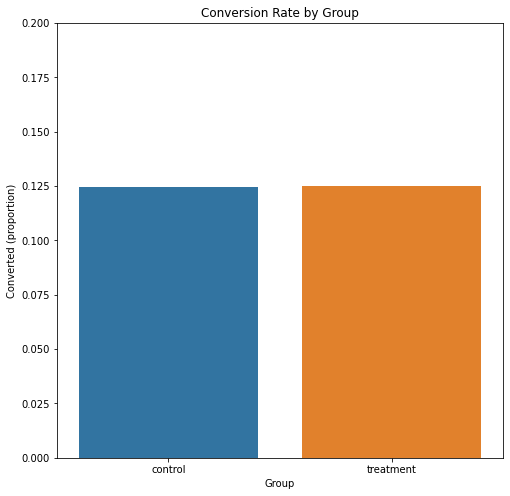

In [15]:
plt.figure(figsize=(8,8))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.2)
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)');

# Chart yang cocok adalah barplot, karena menampilkan data per group dan bukan time series

In [ ]:
"""
Interpretasi

Terlihat dari gambar, conversion rate dari controul group sama dengan treatment group, yaitu 12,5%. 
Tidak ada perbedaan yang signifikan antara old page (control) dan new page (treatment) jika dilihat dari visualisasi tersebut. 
Namun, selanjutnya harus dilakukan pengujian hipotesis untuk mengambil kesimpulan.

"""

# Pengujian Hipotesis

In [11]:
# Menggunakan uji normal Z

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_control = control_results.count()
n_treat = treatment_results.count()
success = [control_results.sum(), treatment_results.sum()]
n = [n_control, n_treat]

z_stat, p_value = proportions_ztest(success, nobs=n)
(lower_control, lower_treat), (upper_control, upper_treat) = proportion_confint(success, nobs=n, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_control:.4f}, {upper_control:.4f}]')
print(f'ci 95% for treatment group: [{lower_treat:.4f}, {upper_treat:.4f}]')

z statistic: -0.07
p-value: 0.947
ci 95% for control group: [0.1146, 0.1348]
ci 95% for treatment group: [0.1151, 0.1353]


In [ ]:
"""
Kesimpulan

Hasil conversion rate dari control group (old page) dan treatment group (new page) adalah 0,1247 dan 0,1252. 
Artinya, tidak ada perbedaan yang signifikan dari conversion rate yang dihasilkan.

Setelah dilakukan pengujian hipotesis, p-value yang didapatkan adalah 0.947, dimana nilai tersebut lebih besar 
dari alpha yang digunakan yaitu 0.05. Artinya, secara statistik, kita harus mengambil keputusan bahwa 
tidak bisa menolak H0.

0.947 > 0.05, maka terima H0.
Artinya, landing page baru tidak memberikan hasil yang signifikan terhadap conversion rate.

Dari hasil pengujian juga kita dapatkan, conversion rate tersebut juga benar sesuai dengan selang kepercayaan 
untuk kedua grup yang didapatkan. Control group di antara 0,1146 dan 0,1348, sedangkan treatment group 
di antara 0,1151 dan 0,1353.

"""